In [10]:
! wget "https://osf.io/drjhb/download"

--2023-05-19 11:12:50--  https://osf.io/drjhb/download
Resolving osf.io (osf.io)... 35.190.84.173
Connecting to osf.io (osf.io)|35.190.84.173|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://files.ca-1.osf.io/v1/resources/hygbm/providers/osfstorage/6106c66bb2d332010cffac63?action=download&direct&version=1 [following]
--2023-05-19 11:12:50--  https://files.ca-1.osf.io/v1/resources/hygbm/providers/osfstorage/6106c66bb2d332010cffac63?action=download&direct&version=1
Resolving files.ca-1.osf.io (files.ca-1.osf.io)... 35.241.38.243
Connecting to files.ca-1.osf.io (files.ca-1.osf.io)|35.241.38.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1301492495 (1.2G) [application/octet-stream]
Saving to: ‘download.1’

download.1          100%[===================>]   1.21G  92.2MB/s    in 15s     

2023-05-19 11:13:06 (82.4 MB/s) - ‘download.1’ saved [1301492495/1301492495]



In [11]:
import os
import json
import math
import librosa

import requests
import pickle

# for progress bar
from tqdm.auto import tqdm

# Download Dataset

In [12]:
ZIP_FILE = "music.zip"
if ZIP_FILE in os.listdir():
  print("Dataset file already exist")
else:
  print("Finding the link to web.....")
  try:
    request = requests.get('https://osf.io/drjhb/download')
  except requests.ConnectionError as err:
    print(f"Error: {err}")
  with open(ZIP_FILE, 'wb') as file:
    file.write(request.content)

Dataset file already exist


In [13]:
# unzip the dataset
from zipfile import ZipFile
with ZipFile(ZIP_FILE, "r") as zipObj:
  zipObj.extractall()

In [14]:
os.listdir()

['.config',
 'music.zip',
 'data_feature.pickle',
 'download',
 'download.1',
 'Data',
 'sample_data']

In [15]:
DATASET_DIR = "/content/Data/genres_original"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # Track duration is 30 sec

# 
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION
print(f"Number of samples per track: {SAMPLES_PER_TRACK}")

Number of samples per track: 661500


In [16]:
def extract_mfcc(SAMPLES_PER_TRACK, parts=5, n_mfcc=13, n_fft=2048, hop_length=512):

  data = {
      "mapping": [],
      "labels": [],
      "mfcc": [],
  }

  samples_per_segment = int(SAMPLES_PER_TRACK / parts)
  mfcc_per_segment = math.ceil(samples_per_segment / hop_length)

  # walk through all genres_original to get raw audio file
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(DATASET_DIR)):
    # select only subfolder of genre
    # file inside DATASET_PATH/ main dir is not included
    if dirpath is not DATASET_DIR:

      # save dir file as label
      label = os.path.basename(dirpath)
      data["mapping"].append(label)
      print(f"Loading file from {label.upper()} genre....")

      # process all raw audio files
      for file in filenames:

        filepath = os.path.join(dirpath, file)
        # load the audio file
        try:
          y, sr = librosa.load(filepath, sr=SAMPLE_RATE)
        except:
          continue

        for part in range(parts):

          # find the start and finish of segment
          start = samples_per_segment * part
          end = start + samples_per_segment

          # extract mfcc
          mfcc = librosa.feature.mfcc(y=y[start:end], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
          mfcc = mfcc.T

          if len(mfcc) == mfcc_per_segment:
            data["mfcc"].append(mfcc)
            data["labels"].append(i-1)
          else:
            print(f"[INFO] {part} segment of {file} is not included ")
  with open('data_feature.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
  return data

feature = extract_mfcc(SAMPLES_PER_TRACK=SAMPLES_PER_TRACK, parts=5, n_mfcc=13, n_fft=2048, hop_length=512)

Loading file from BLUES genre....
Loading file from HIPHOP genre....
[INFO] 4 segment of hiphop.00032.wav is not included 
Loading file from ROCK genre....
Loading file from POP genre....
Loading file from DISCO genre....
Loading file from REGGAE genre....
Loading file from JAZZ genre....


<ipython-input-16-2f819e27e0ed>:29: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(filepath, sr=SAMPLE_RATE)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Loading file from COUNTRY genre....
[INFO] 4 segment of country.00007.wav is not included 
Loading file from CLASSICAL genre....
Loading file from METAL genre....


In [17]:
# Import the required libraries
from collections import Counter
import numpy as np

# Load feature mapping and labels into variables
labels_name = feature["mapping"]
labels = np.array(feature["labels"])

# Count the occurrences of each label
counter = Counter(labels)

# Print the count of each label
print(f"labels_name: {labels_name}")
counter

labels_name: ['blues', 'hiphop', 'rock', 'pop', 'disco', 'reggae', 'jazz', 'country', 'classical', 'metal']


Counter({0: 500,
         1: 499,
         2: 500,
         3: 500,
         4: 500,
         5: 500,
         6: 495,
         7: 499,
         8: 500,
         9: 500})

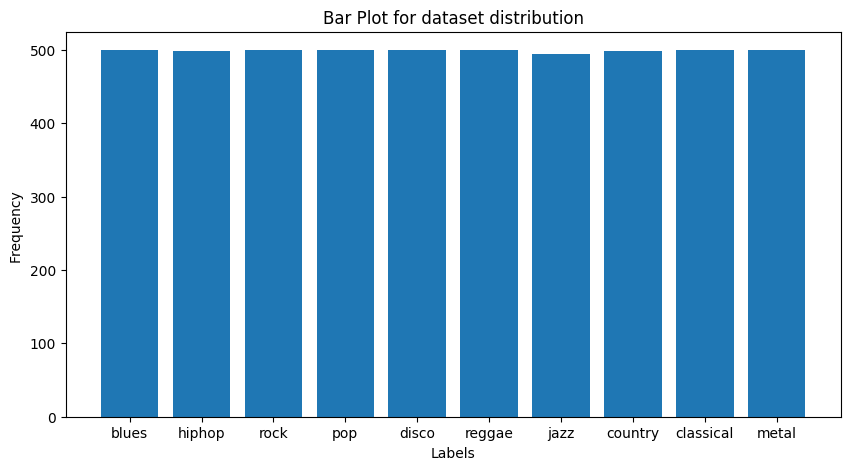

In [18]:
# Import the necessary libraries
from matplotlib import pyplot as plt

# Set the figure size of the plot
plt.figure(figsize=(10, 5))

# Create a bar plot using the provided data
plt.bar(labels_name, height=counter.values())

# Set the title of the plot
plt.title("Bar Plot for dataset distribution")

# Label the x-axis
plt.xlabel("Labels")

# Label the y-axis
plt.ylabel("Frequency ")

# Display the plot
plt.show()

In [19]:
# Convert the "mfcc" feature dictionary to a numpy array
mfcc = np.array(feature["mfcc"])

# Normalize the values of the "mfcc" array to be between 0 and 1
mfcc = mfcc / np.max(mfcc)

# Print the shape of the normalized "mfcc" array
print(f"Shape of mfcc: {mfcc.shape}")
print(f"Shape of a element in dataset: {mfcc[0].shape}")

Shape of mfcc: (4993, 259, 13)
Shape of a element in dataset: (259, 13)


In [20]:
# plt.plot(mfcc[0])
# plt.legend()
# plt.show()

Text(0.5, 1.0, 'MFCCs')

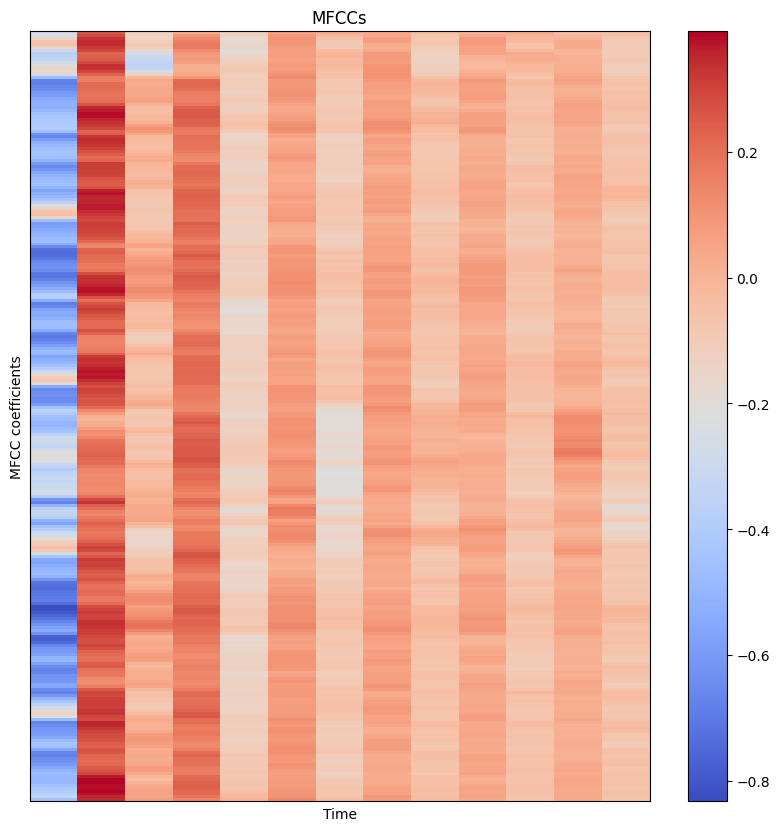

In [21]:
# display MFCCs
plt.figure(figsize=(10, 10))
librosa.display.specshow(mfcc[0], sr=SAMPLE_RATE, hop_length=512)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

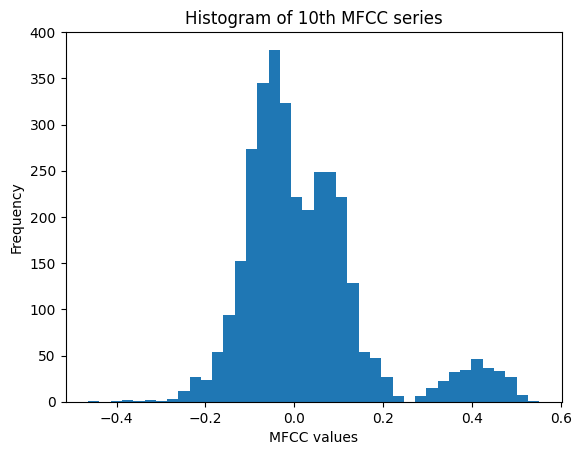

In [22]:
# Select the 10th row of the "mfcc" array, which represents one series of MFCC coefficients
mfcc_series = mfcc[10, :]

# Reshape the selected series to a 1D array using the "view" method, then flatten it to remove any nested arrays
mfcc_series_flat = mfcc_series.view().reshape(-1)

# Create a histogram of the flattened "mfcc_series_flat" array with 40 bins
plt.hist(mfcc_series_flat, bins=40)

# Set the title of the plot
plt.title("Histogram of 10th MFCC series")

# Label the y-axis
plt.ylabel("Frequency")

# Label the x-axis
plt.xlabel("MFCC values")

# Display the plot
plt.show()

In [23]:
# Expand the dimension in 3 dimension
mfcc = np.expand_dims(mfcc, -1)

In [24]:
# Import the necessary library for splitting the dataset into training and testing sets
from sklearn.model_selection import train_test_split

# Split the "mfcc" and "labels" arrays into training and testing sets with a test size of 20% and a random state of 42
X_train, X_test, Y_train, Y_test = train_test_split(mfcc, labels, test_size=0.2, random_state=42)

# Print the shape of the "X_train" array
print(f"Shape of X_train: {X_train.shape}")

# Print the shape of the "X_test" array
print(f"Shape of X_test: {X_test.shape}")

# Print the number of training and testing data points, respectively
print(f"Total training data label: {len(Y_train)} and testing data label: {len(Y_test)}")


Shape of X_train: (3994, 259, 13, 1)
Shape of X_test: (999, 259, 13, 1)
Total training data label: 3994 and testing data label: 999


In [25]:
# Import the necessary libraries
import datetime
import tensorflow as tf
from tensorflow import keras

In [53]:
input_shape = X_test[0].shape
input_shape

(259, 13, 1)

In [27]:
# CNN network architecture
def create_model(input_shape, activation="relu"):
  model = keras.models.Sequential()
  model.add(keras.Input(shape=input_shape))
  model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model.add(keras.layers.Conv2D(54, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
  model.add(keras.layers.MaxPool2D(pool_size=(2, 2), padding="same"))
  model.add(keras.layers.Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
  model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), padding="same"))
  model.add(keras.layers.Conv2D(54, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
  model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(10, activation="softmax"))
  # Return the model
  return model


In [28]:
# Create a neural network model using the function defined earlier
model = create_model(input_shape, activation="relu")

# Define the loss function and optimizer for the model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Compile the model with the chosen optimizer and loss function, and specify accuracy as a metric to track
model.compile(optimizer=optimizer,
              loss=loss_object,
              metrics=['accuracy'])

# Define a log directory for TensorBoard to track training progress, and set up a callback to use it
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Print a summary of the model architecture to the console
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 259, 13, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 129, 6, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 129, 6, 54)        15606     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 65, 3, 54)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 65, 3, 32)         15584     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 33, 2, 32)        0

In [29]:
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [30]:
# Train the model on the training data for 50 epochs, with 20% of the data used for validation
# Also use the TensorBoard callback to track progress during training
model.fit(X_train, Y_train,
          epochs=50, validation_split=0.2,
          callbacks=[tensorboard_callback])

Epoch 1/50
100/100 [==============================] - 23s 217ms/step - loss: 2.0526 - accuracy: 0.2169 - val_loss: 1.6929 - val_accuracy: 0.4055
Epoch 2/50
100/100 [==============================] - 19s 191ms/step - loss: 1.6663 - accuracy: 0.3750 - val_loss: 1.5485 - val_accuracy: 0.4293
Epoch 3/50
100/100 [==============================] - 20s 201ms/step - loss: 1.4875 - accuracy: 0.4379 - val_loss: 1.4073 - val_accuracy: 0.4919
Epoch 4/50
100/100 [==============================] - 19s 194ms/step - loss: 1.4195 - accuracy: 0.4629 - val_loss: 1.3031 - val_accuracy: 0.5294
Epoch 5/50
100/100 [==============================] - 20s 195ms/step - loss: 1.3018 - accuracy: 0.5099 - val_loss: 1.2747 - val_accuracy: 0.5319
Epoch 6/50
100/100 [==============================] - 19s 193ms/step - loss: 1.2091 - accuracy: 0.5562 - val_loss: 1.2639 - val_accuracy: 0.5307
Epoch 7/50
100/100 [==============================] - 18s 184ms/step - loss: 1.1387 - accuracy: 0.5768 - val_loss: 1.1087 - val_ac

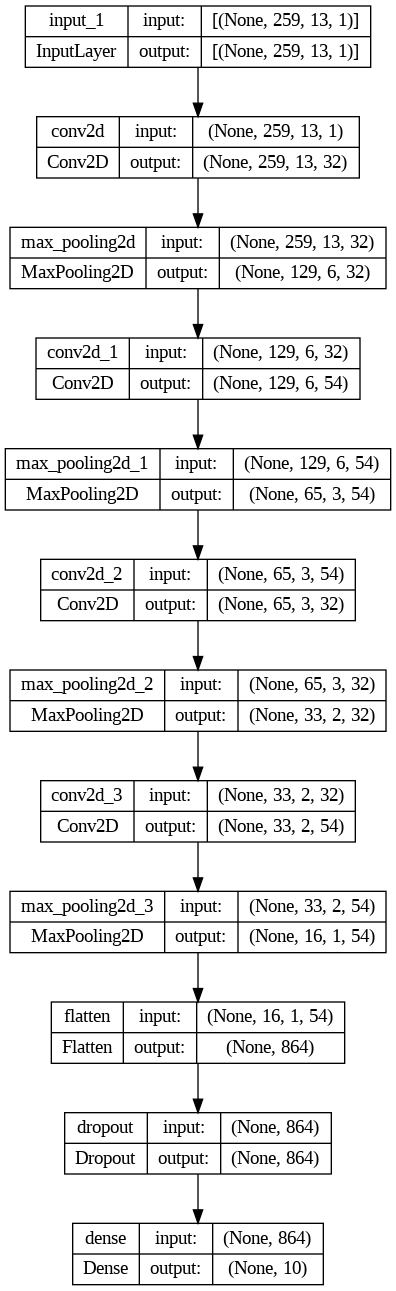

In [31]:
tf.keras.utils.plot_model(
    model,
    to_file='model_linear.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

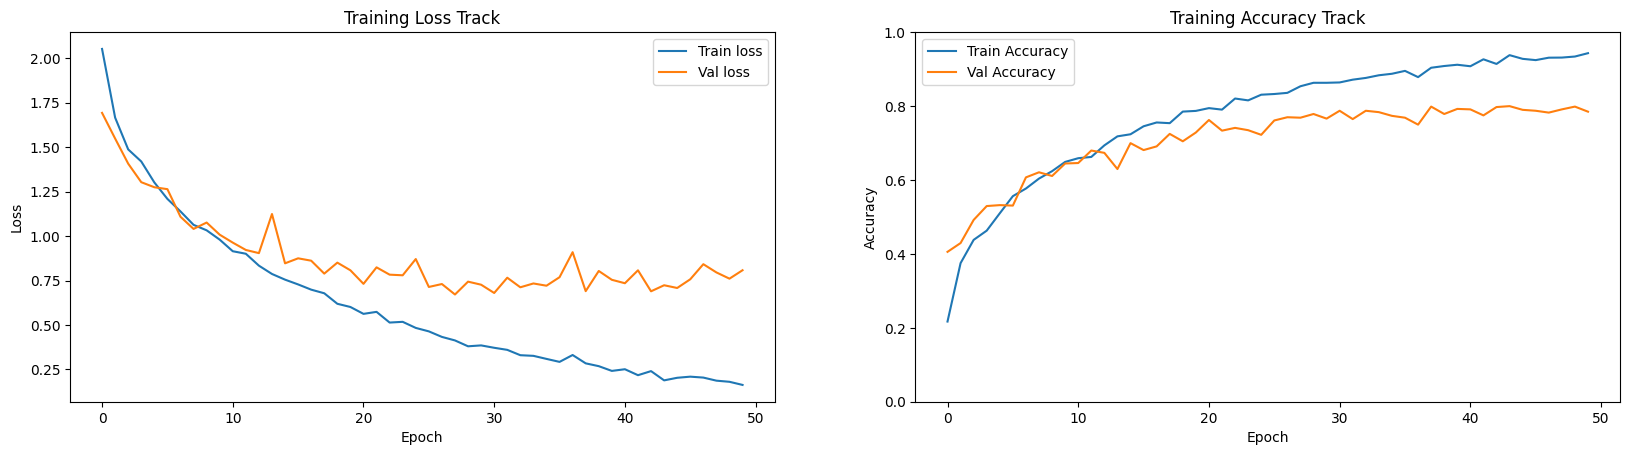

In [32]:
def polt_history(history):

  fig, ax = plt.subplots(1, 2)
  fig.set_figwidth(20)
  epochs = np.arange(0, len(history["loss"]), 1)

  ax[0].plot(epochs, history["loss"], label="Train loss")
  ax[0].plot(epochs, history["val_loss"], label="Val loss")
  ax[0].set_xlabel("Epoch")
  ax[0].set_ylabel("Loss")
  ax[0].set_title("Training Loss Track")
  ax[0].legend()

  ax[1].plot(epochs, history["accuracy"], label="Train Accuracy")
  ax[1].plot(epochs, history["val_accuracy"], label="Val Accuracy")
  ax[1].set_xlabel("Epoch")
  ax[1].set_ylabel("Accuracy")
  ax[1].set_title("Training Accuracy Track") 
  ax[1].set_ylim(0, 1)
  ax[1].legend()

  plt.show()

history = model.history
polt_history(history.history)

In [33]:
# Save of model
model.save('my_cnn_model_for_mfcc.h5')

In [34]:
# from tensorflow.keras.models import load_model

# model = load_model("my_cnn_model_for_mfcc.h5")

In [35]:
predict = model.predict(X_test)
predict_label = np.argmax(predict, axis=-1)

32/32 [==============================] - 2s 44ms/step


In [36]:
print(f"Total number of test sample predicted: ", predict_label.shape, Y_test.shape)
assert predict_label.shape == Y_test.shape

Total number of test sample predicted:  (999,) (999,)


Text(50.722222222222214, 0.5, 'Actual Class')

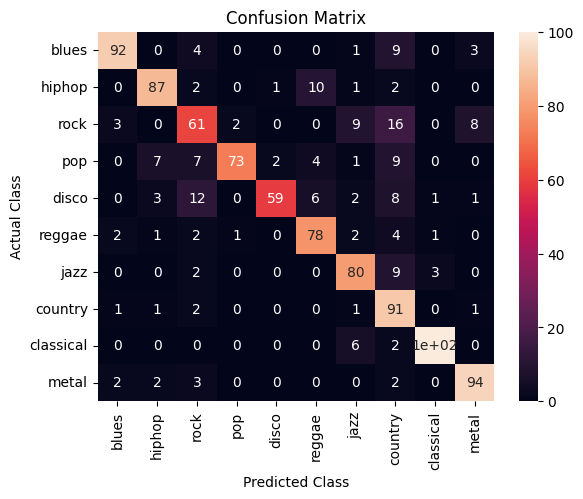

In [37]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_true=Y_test, y_pred=predict_label)
sns.heatmap(cm, annot=True, xticklabels=labels_name, yticklabels=labels_name)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")

In [38]:
print(classification_report(y_true=Y_test, y_pred=predict_label))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       109
           1       0.86      0.84      0.85       103
           2       0.64      0.62      0.63        99
           3       0.96      0.71      0.82       103
           4       0.95      0.64      0.77        92
           5       0.80      0.86      0.83        91
           6       0.78      0.85      0.81        94
           7       0.60      0.94      0.73        97
           8       0.95      0.93      0.94       108
           9       0.88      0.91      0.90       103

    accuracy                           0.82       999
   macro avg       0.83      0.81      0.81       999
weighted avg       0.84      0.82      0.82       999



## Testing with new music

In [63]:
import librosa
import math 
import numpy as np

def get_mfcc(music_path, parts=5, n_mfcc=13, n_fft=2048, hop_length=512):
  SAMPLE_RATE = 22050
  SEGMENT_LENGTH = 6 #in sec
  # Divide given music in  6 sec segment
  samples_per_segment = SEGMENT_LENGTH* 22050
  mfcc_per_segment = math.ceil(samples_per_segment / hop_length)
  try:
    y, sr = librosa.load(music_path, sr=SAMPLE_RATE)
    durations = librosa.get_duration(y=y, sr=sr)
    parts = int(durations/ SEGMENT_LENGTH)
  except:
    print(f"[INFO] Please check given music path: {music_path}.")
    return None
  music_all_mfcc = []
  for part in range(parts):
  # find the start and finish of segment
    start = samples_per_segment * part
    end = start + samples_per_segment

    # extract mfcc
    mfcc = librosa.feature.mfcc(y=y[start:end], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfcc = mfcc.T

    if len(mfcc) == mfcc_per_segment:
      # resize to fit in cnn model
      mfcc = np.resize(mfcc, (mfcc.shape[0], mfcc.shape[1], 1))
      music_all_mfcc.append(mfcc)
    else:
      print(f"[INFO] {part} segment of {file} is not included ")
  return np.array(music_all_mfcc)
  

In [65]:
test_mfcc = get_mfcc("test.wav")
test_mfcc.shape

(8, 259, 13, 1)

In [67]:
predictions = []

print(f"Shape is: {test_mfcc.shape}")
prediction = model.predict(test_mfcc)


Shape is: (8, 259, 13, 1)
1/1 [==============================] - 0s 33ms/step


In [71]:
prediction

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99999994, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.99999994, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99999994, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99999994, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.99999994, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99999994, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.99999994, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [73]:
mean_pred = np.mean(prediction, axis=0)

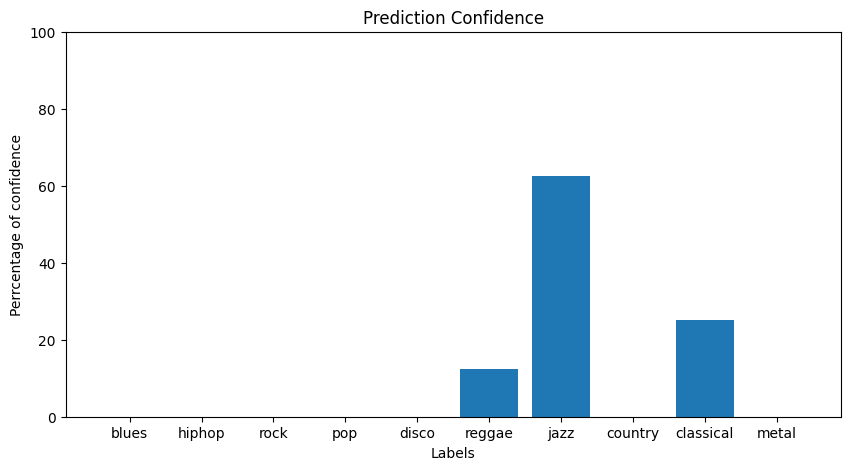

In [76]:
plt.figure(figsize=(10, 5))
plt.bar(labels_name, height=mean_pred*100)

# Plot for percentage of confidence
plt.title("Prediction Confidence")
plt.xlabel("Labels")
plt.ylabel("Perrcentage of confidence")
plt.ylim(0,100)
plt.show()